In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error
from datetime import datetime
import pymc3 as pm
import arviz as az
from scipy.stats import norm
from scipy import  stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import arch 
pd.set_option('display.max_rows',200)
import time

import warnings
warnings.filterwarnings("ignore")


In [2]:
#上证50
df1=pd.read_csv('./上证50ETF.csv',index_col=0)
#df1['returns']=df1['CLOSE'].pct_change()
df1['returns']=np.log(df1['CLOSE']).diff()
df1['history_volatility']=df1['returns'].rolling(20).std()*np.sqrt(250)
df1=df1['2021/1/29':'2021/9/17']
df1=df1[['CLOSE','returns','history_volatility']]

#期权
df2=pd.read_csv('./50ETF购2021年9月.csv',index_col=0)

#国债利率
df3=pd.read_csv('./国债利率.csv',index_col=0)
df3=df3.fillna(method='pad')/100
df3=df3['2021/1/29':'2021/9/17']

In [3]:
df1.head()

,CLOSE,returns,history_volatility
DateTime,,,
2021/1/29,3.704,-0.007263,0.225284
2021/2/1,3.731,0.007263,0.226288
2021/2/2,3.752,0.005613,0.224237
2021/2/3,3.764,0.003193,0.218523
2021/2/4,3.787,0.006092,0.206861


In [4]:
df2.head()

,10003575.SH2.85,10003513.SH2.90,10003505.SH2.95,10003371.SH3.00,10003317.SH3.10,10003305.SH3.20,10003241.SH3.30,10003205.SH3.40,10003206.SH3.50,10003207.SH3.60,10003208.SH3.70,10003209.SH3.80,10003210.SH3.90,10003211.SH4.00,10003212.SH4.10,10003213.SH4.20,10003251.SH4.30,10003261.SH4.40
DateTime,,,,,,,,,,,,,,,,,,
2021/1/29,NaN,NaN,NaN,NaN,NaN,NaN,0.5465,0.4800,0.4088,0.3517,0.3051,0.2562,0.2154,0.1808,0.1467,0.1275,NaN,NaN
2021/2/1,NaN,NaN,NaN,NaN,NaN,NaN,0.5599,0.4889,0.4239,0.3642,0.3112,0.2673,0.2236,0.1881,0.1590,0.1333,NaN,NaN
2021/2/2,NaN,NaN,NaN,NaN,NaN,NaN,0.5697,0.4940,0.4273,0.3663,0.3115,0.2636,0.2195,0.1858,0.1555,0.1305,NaN,NaN
2021/2/3,NaN,NaN,NaN,NaN,NaN,NaN,0.5674,0.4888,0.4260,0.3656,0.3050,0.2578,0.2162,0.1805,0.1493,0.1249,NaN,NaN
2021/2/4,NaN,NaN,NaN,NaN,NaN,NaN,0.5747,0.5077,0.4395,0.3775,0.3201,0.2719,0.2287,0.1890,0.1568,0.1314,NaN,NaN


In [5]:
def get_data(name):
    df=pd.DataFrame(df2[name])
    df.columns=['price']
    df['K']=float(name[-4:])
    T=datetime.strptime('2021-9-22', '%Y-%m-%d')
    df['T']=((T-pd.DatetimeIndex(df2.index)).days.values+1)/365
    df['S']=df1['CLOSE'].values
    df['r']=df3['TB1Y.WI'].values
    return df
    

# BS模型

In [6]:
def my_bs_call(S, K, T, r, sigma):
    if np.isnan(sigma):
        return np.nan
    d1 = (np.log(S/K) + (r+.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    N1, N2 = norm.cdf(d1), norm.cdf(d2)
    return S*N1 - K*np.exp(-r*T)*N2

# GARCH(1,1)

In [7]:
am = arch.arch_model(df1['returns'].values) 
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 39310.53865457693
Iteration:      2,   Func. Count:     18,   Neg. LLF: 226235.5944548131
Iteration:      3,   Func. Count:     28,   Neg. LLF: -456.3728726740908
Optimization terminated successfully    (Exit mode 0)
            Current function value: -456.37287281301184
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                456.373
Distribution:                  Normal   AIC:                          -904.746
Method:            Maximum Likelihood   BIC:                          -892.546
                                        No. Observations:                  156
Date:                Fri, Apr 29 2022   Df Residuals:                      152
Time:                        15:18:09   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.7185e-04  1.038e-03     -0.937      0.349 [-3.006e-03,1.062e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.6900e-05  1.964e-11  8.604e+05      0.000  [1.690e-05,1.690e-05]
alpha[1]       0.0100  3.624e-02      0.276      0.783 [-6.103e-02,8.103e-02]
beta[1]        0.8900  4.157e-02     21.411 1.061e-101      [  0.809,  0.971]
=============================================================================

Covariance estimator: robust
"""

In [8]:
g_sigma=res.conditional_volatility*np.sqrt(250)

In [9]:
def MSE(x,y):
    DF=pd.DataFrame([x,y]).T
    DF.columns=['predict','real']
    DF=DF.dropna(axis=0)
    return mean_squared_error(DF['predict'],DF['real'])

In [10]:
h_mse=[]
for name in df2.columns[:10]:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        result=my_bs_call(S, K, T, r, sigma=df1['history_volatility'].values[i])
        predict.append(result)
    predict=np.array(predict)
    h_mse.append(MSE(predict,df['price'].values))
mse=pd.DataFrame(h_mse)
mse.columns=['history-BS']
mse.index=df2.columns[:10]

In [11]:
garch_mse=[]
for name in df2.columns[:10]:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        result=my_bs_call(S, K, T, r, sigma=g_sigma[i])
        predict.append(result)
    predict=np.array(predict)
    garch_mse.append(MSE(predict,df['price'].values))


In [12]:
mse['Garch-BS']=garch_mse
mse

,history-BS,Garch-BS
10003575.SH2.85,0.000036,0.000034
10003513.SH2.90,0.000231,0.000140
10003505.SH2.95,0.000336,0.000190
10003371.SH3.00,0.000450,0.000600
10003317.SH3.10,0.001529,0.000950
10003305.SH3.20,0.001679,0.000924
10003241.SH3.30,0.001656,0.000798
10003205.SH3.40,0.001566,0.000617
10003206.SH3.50,0.001401,0.000450
10003207.SH3.60,0.001260,0.000279


# SV

history_volatility_mse=[]
for name in df2.columns:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        result=my_bs_call(S, K, T, r=0.05, sigma=df1['history_volatility'].values[i])
        predict.append(result)
    predict=np.array(predict)
    history_volatility_mse.append(mean_absolute_error(predict,df['price'].values))

mse['history_volatility-BS']=history_volatility_mse

In [13]:
def make_stochastic_volatility_model2(data):
    with pm.Model() as model:
        mu = pm.Normal('mu',0,0.1)
        fi1=pm.Beta('fi1',20,1.5)
        fi=2*fi1-1
        tau=pm.Gamma('tau',2.5,0.025)
        v = pm.AR1("v", k=fi,tau_e=tau, shape=len(data))
        volatility=v+mu
        nu = pm.ChiSquared("nu", 8)
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-1 * volatility), observed=data['returns'])
    return model


stochastic_vol_model2 = make_stochastic_volatility_model2(df1)


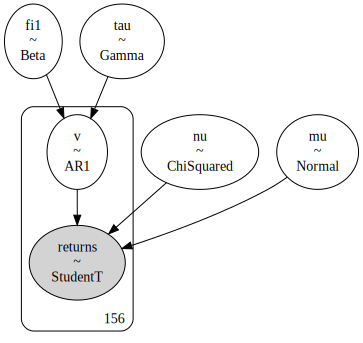

In [14]:
pm.model_to_graphviz(stochastic_vol_model2)

In [15]:
with stochastic_vol_model2:
    #start=pm.find_MAP()
    step=pm.NUTS()
    trace = pm.sample(draws=20000, tune=20000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, v, tau, fi1, mu]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 4714 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.005,0.100,-0.192,0.182,0.000,0.000,51526.0,55026.0,1.0
v[0],-8.755,0.524,-9.767,-7.786,0.003,0.002,32988.0,25037.0,1.0
v[1],-8.753,0.507,-9.717,-7.795,0.003,0.002,32206.0,23611.0,1.0
v[2],-8.745,0.490,-9.682,-7.821,0.003,0.002,31635.0,25905.0,1.0
v[3],-8.730,0.474,-9.636,-7.843,0.003,0.002,32714.0,27456.0,1.0
v[4],-8.706,0.455,-9.561,-7.839,0.002,0.002,37537.0,30341.0,1.0
v[5],-8.674,0.436,-9.485,-7.836,0.002,0.001,44548.0,36821.0,1.0
v[6],-8.643,0.420,-9.447,-7.859,0.002,0.001,47205.0,47116.0,1.0
v[7],-8.608,0.407,-9.391,-7.853,0.002,0.001,47390.0,50797.0,1.0
v[8],-8.577,0.399,-9.329,-7.829,0.002,0.001,47132.0,49415.0,1.0


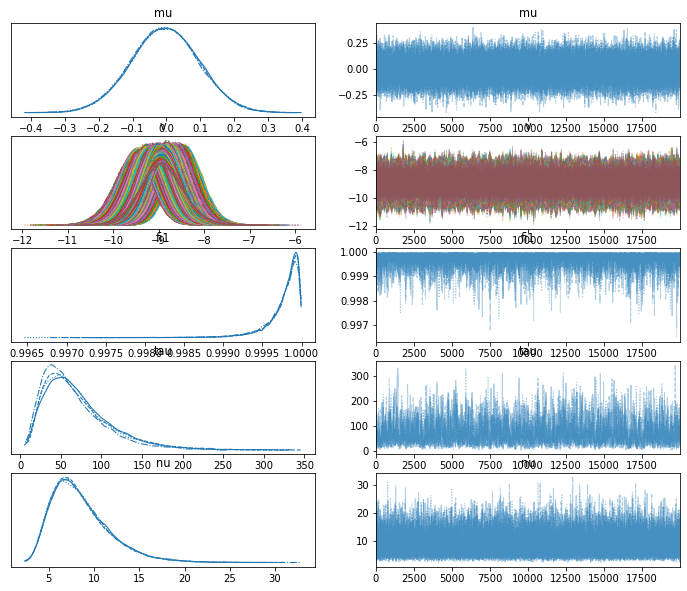

In [16]:
pm.traceplot(trace)
pm.summary(trace)

In [20]:
sv_sigma=np.sqrt(np.exp(pd.DataFrame(trace['v']).T.mean(axis=1).values+np.mean(trace['mu'])))*np.sqrt(250)
sv_mse=[]
for name in df2.columns[:5]:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        result=my_bs_call(S, K, T, r, sigma=sv_sigma[i])
        predict.append(result)
    predict=np.array(predict)
    sv_mse.append(MSE(predict,df['price'].values))

mse['SV-BS']=sv_mse
mse

[0.19848382 0.19861713 0.19939576 0.20088082 0.20333745 0.20650299
 0.20982716 0.2133728  0.21646872 0.21888293 0.22233663 0.2270642
 0.22910526 0.23234686 0.23389435 0.23545279 0.23551215 0.23638187
 0.2368435  0.2357268  0.23267517 0.23059612 0.22606232 0.22144713
 0.21782702 0.21253873 0.20840651 0.20389739 0.20007583 0.19737089
 0.1954808  0.19139636 0.18790545 0.18510631 0.18200072 0.17982131
 0.17674757 0.17457962 0.17226628 0.17009392 0.16778597 0.1656121
 0.1639992  0.16231341 0.16131694 0.15960752 0.15766519 0.15621523
 0.15554023 0.15473801 0.15454206 0.15288002 0.15190433 0.15159219
 0.15176995 0.15200391 0.15121404 0.15108988 0.15167049 0.1516859
 0.15172108 0.15157213 0.15083309 0.15086578 0.15099114 0.15167912
 0.15229038 0.15044231 0.14855943 0.14750827 0.14672595 0.14652032
 0.14595815 0.14593253 0.1420904  0.13893364 0.13638969 0.13454849
 0.13326891 0.13262424 0.13209632 0.13152541 0.13131331 0.13169337
 0.13229222 0.13348492 0.13499024 0.13649764 0.13711102 0.1374316

,history-BS,Garch-BS,SV-BS
10003575.SH2.85,0.000036,0.000034,0.000029
10003513.SH2.90,0.000231,0.000140,0.000115
10003505.SH2.95,0.000336,0.000190,0.000149
10003371.SH3.00,0.000450,0.000600,0.000309
10003317.SH3.10,0.001529,0.000950,0.000421


In [22]:
mcresult=pd.read_excel('./mcresult.xlsx',index_col=0)

In [28]:
trace_v=mcresult['mean'].iloc[1:-3].values
trace_mu=mcresult['mean'][0]

In [31]:
sv_sigma=np.sqrt(np.exp(trace_v+trace_mu))*np.sqrt(250)
sv_mse=[]
for name in df2.columns[:10]:
    df=get_data(name)
    predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        result=my_bs_call(S, K, T, r, sigma=sv_sigma[i])
        predict.append(result)
    predict=np.array(predict)
    sv_mse.append(MSE(predict,df['price'].values))

mse['SV-BS']=sv_mse
mse

,history-BS,Garch-BS,SV-BS
10003575.SH2.85,0.000036,0.000034,0.000029
10003513.SH2.90,0.000231,0.000140,0.000115
10003505.SH2.95,0.000336,0.000190,0.000149
10003371.SH3.00,0.000450,0.000600,0.000309
10003317.SH3.10,0.001529,0.000950,0.000422
10003305.SH3.20,0.001679,0.000924,0.000303
10003241.SH3.30,0.001656,0.000798,0.000380
10003205.SH3.40,0.001566,0.000617,0.000352
10003206.SH3.50,0.001401,0.000450,0.000409
10003207.SH3.60,0.001260,0.000279,0.000469


In [35]:
h_sigma=df1['history_volatility'].values

In [36]:
def option_plot(name):
    df=get_data(name)
    h_predict=[]
    g_predict=[]
    sv_predict=[]
    for i in range(len(df)):
        S=df['S'].iloc[i]
        K=df['K'].iloc[i]
        T=df['T'].iloc[i]
        r=df['r'].iloc[i]
        h_result=my_bs_call(S, K, T, r, sigma=h_sigma[i])
        g_result=my_bs_call(S, K, T, r, sigma=g_sigma[i])
        sv_result=my_bs_call(S, K, T, r, sigma=sv_sigma[i])
        h_predict.append(h_result)
        g_predict.append(g_result)
        sv_predict.append(sv_result)
    result=pd.DataFrame(df['price'])
    result['hv-BS']=h_predict
    result['Garch-BS']=g_predict
    result['Bayesian-BS']=sv_predict
    result=result.dropna()
    result.plot(figsize=(12,10))
    plt.title(f'K={name[-4:]}')
    return result

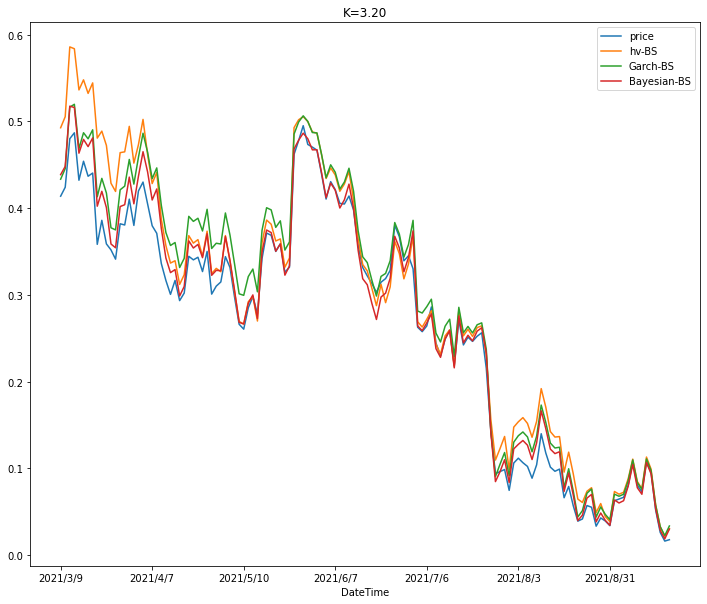

In [39]:
df=option_plot(df2.columns[5])

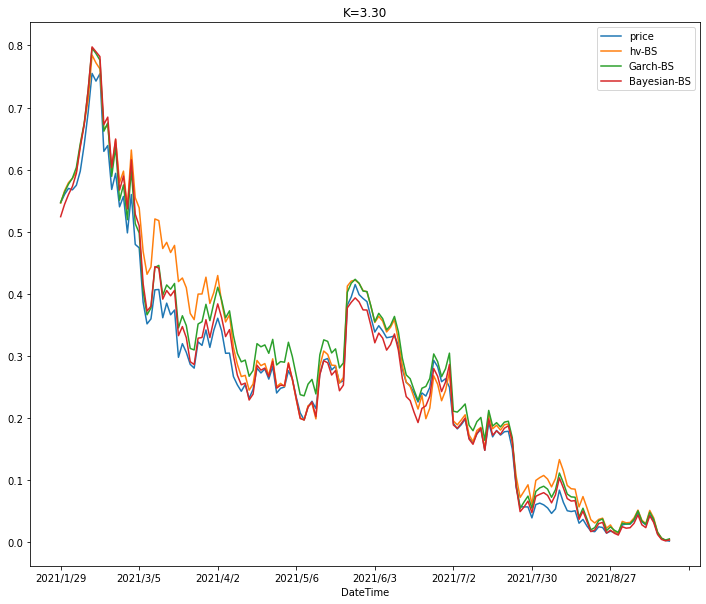

In [40]:
df=option_plot(df2.columns[6])

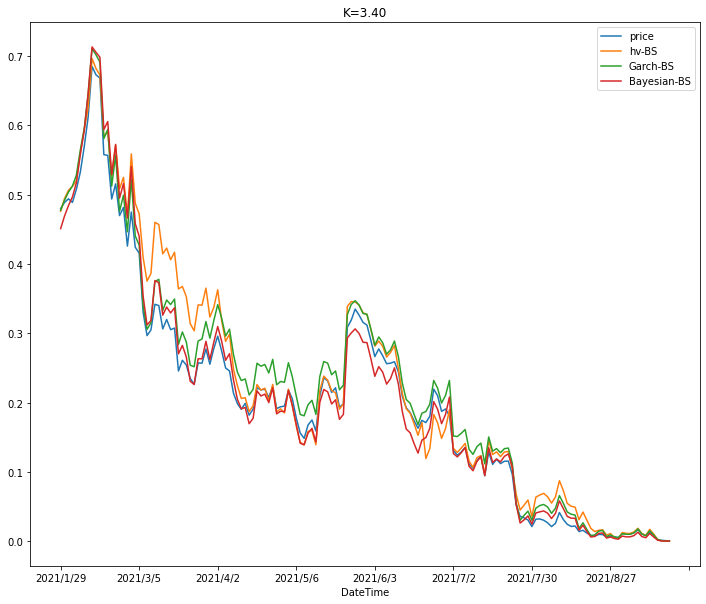

In [41]:
df=option_plot(df2.columns[7])

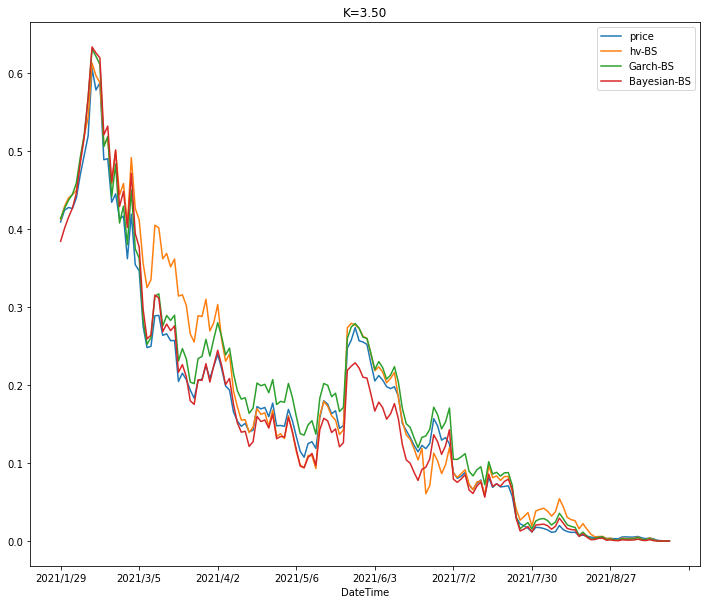

In [42]:
df=option_plot(df2.columns[8])

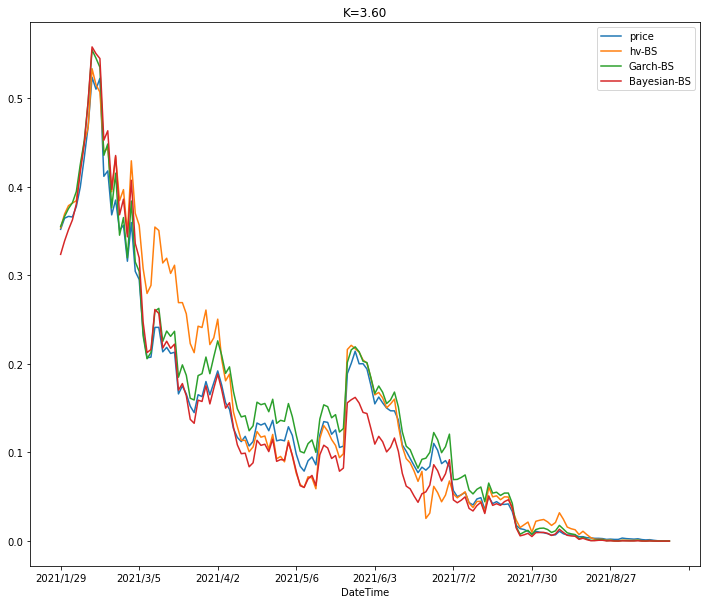

In [43]:
df=option_plot(df2.columns[9])

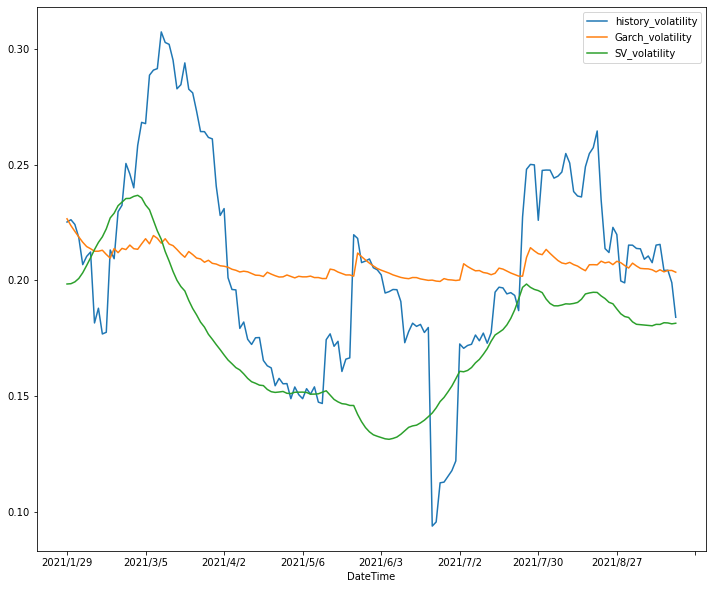

In [63]:
vol=df1.copy()
vol['Garch_volatility']=g_sigma
vol['SV_volatility']=sv_sigma
vol=vol[['history_volatility','Garch_volatility','SV_volatility']]
vol.plot(figsize=(12,10))